## Country-level INFRA-SAP

- Origins: Population grid (Worldpop downsampled to 500 meters)
- Destinations: Cities, airports, border crossings, and ports

Typical access analysis with two adjustments:
    1. Extract different sets of destinations from OD
    2. Join travel time to origin grid based on "NN with the fastest route" (not necessarily closest NN)

In [1]:
import os, sys, time, importlib

import geopandas as gpd
import pandas as pd
import networkx as nx
sys.path.append('/home/wb514197/Repos/GOSTnets')

import GOSTnets as gn
import GOSTnets.calculate_od_raw as calcOD
from GOSTnets.load_osm import *
import rasterio as rio
from osgeo import gdal
import numpy as np
from shapely.geometry import Point

sys.path.append('/home/wb514197/Repos/INFRA_SAP')
from infrasap import aggregator

%load_ext autoreload
%autoreload 2

In [2]:
country = 'djibouti'
iso3 = 'DJI'
epsg = 32638

### Load origins and graph

In [3]:
# base_in = "/home/public/Data/PROJECTS/INFRA_SAP"
base_in = "/home/wb514197/data/INFRA_SAP"
in_folder = os.path.join(base_in, iso3)

# define data paths
focal_admin2 = os.path.join(in_folder, "admin.shp")
focal_osm = os.path.join(in_folder, f"{country}-latest.osm.pbf")
pop_name = "WP_2020_1km"
wp_1km = os.path.join(in_folder, f"{pop_name}.tif")
urban_extents = os.path.join(in_folder, "urban_extents.shp")
airports = os.path.join(in_folder, "airports_intl.shp")
ports = os.path.join(in_folder, "ports.shp")
borders = os.path.join(in_folder, "borders.shp")

# base_out = "/home/wb514197/data/INFRA_SAP" # GOT permission denied using public 
# out_folder = os.path.join(base_out, iso3)
# if not os.path.exists(out_folder):
#     os.makedirs(out_folder)

out_folder = os.path.join(in_folder, "output")

Convert **WP_2020_1km.tif** into a point GeoData frame

In [4]:
inDs = gdal.Open(wp_1km)
out_pop = os.path.join(out_folder, f"{pop_name}.xyz")
outDs = gdal.Translate(out_pop, inDs, format='XYZ', creationOptions=["ADD_HEADER_LINE=YES"])
out_pop_csv = os.path.join(out_folder, f"{pop_name}.csv")
os.rename(out_pop, out_pop_csv)

In [5]:
wp_df = pd.read_csv(out_pop_csv, sep=' ')
wp_df.rename(columns={"Z":"Pop"}, inplace=True)
wp_df = wp_df.loc[wp_df.Pop!=-99999.0].copy()
geoms = [Point(xy) for xy in zip(wp_df.X, wp_df.Y)]
wp_df.drop(["X","Y"], axis=1, inplace=True)
crs = 'EPSG:4326'
origins = gpd.GeoDataFrame(wp_df, crs=crs, geometry=geoms)
origins['pointid'] = origins.index

### Prepare Graph

In [6]:
G_path = None # if a graph already exists list the path here
# G_path = os.path.join(in_folder, 'graph', f"G_{iso3}.pickle") 

In [7]:
if G_path is None:
    print("Creating graph from scratch")
    osm_raw = OSM_to_network(focal_osm)
    accepted_road_types = ['trunk','trunk_link','primary','primary_link','secondary','secondary_link','tertiary','tertiary_link']
    osm_raw.filterRoads(acceptedRoads = accepted_road_types)
    osm_raw.generateRoadsGDF(verbose = False)
    osm_raw.initialReadIn()
    
    if not os.path.exists(os.path.join(out_folder, 'graph')):
        os.mkdir(os.path.join(out_folder, 'graph'))
    gn.save(osm_raw.network,f'G_{iso3}_unclean',os.path.join(out_folder, 'graph'))
    
    #clean graph
    G_clean = gn.clean_network(osm_raw.network, UTM = f"EPSG:{epsg}", WGS = "EPSG:4326", junctdist = 50, verbose = False)
    G = G_clean.copy()

else:
    G = nx.read_gpickle(G_path)
    for u, v, data in G.edges(data = True):
        if type(data['Wkt']) == list:
            data['Wkt'] = gn.unbundle_geometry(data['Wkt'])

Creating graph from scratch


/home/wb514197/.conda/envs/geo/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


401
686
208
404
Edge reduction: 945 to 404 (57 percent)


In [4]:
gn.convert_network_to_time?

In [8]:
# Salt network
attr_list = ['id', 'infra_type', 'osm_id', 'key', 'Type']
G_salt = gn.salt_long_lines(G, source='EPSG:4326', target=f'EPSG:{epsg}', thresh=5000, factor=1000, attr_list=attr_list)
G_time = gn.convert_network_to_time(G_salt, distance_tag = 'length', road_col = 'infra_type', factor = 1000)
if not os.path.exists(os.path.join(out_folder, 'graph')):
    os.mkdir(os.path.join(out_folder, 'graph'))
gn.save(G_time, f"G_{iso3}_Salt", os.path.join(out_folder, 'graph'))

Identified 33 unique edge(s) longer than 5000. 
Beginning new node creation...


/home/wb514197/.conda/envs/geo/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/wb514197/.conda/envs/geo/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/wb514197/.conda/envs/geo/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When m

454 new edges added and 66 removed to bring total edges to 792
194 new nodes added to bring total nodes to 330


In [7]:
# G_time = nx.read_gpickle(os.path.join(out_folder, 'graph', f'G_{iso3}_Salt.pickle'))

#### Select largest graph

In [9]:
list_of_subgraphs = [G_time.subgraph(c).copy() for c in sorted(nx.strongly_connected_components(G_time), key=len, reverse=True)]
G_largest = list_of_subgraphs[0]

### Prepare destinations

In [15]:
inCities = gpd.read_file(urban_extents)
pop_thresh = 0
# pop_thresh=50000
inCities = inCities.loc[inCities.Pop>pop_thresh]
inCities['geometry'] = inCities.geometry.centroid
dest_cities = inCities.assign(dest_type = 'city')

In [13]:
inCities = gpd.read_file(urban_extents)
len(inCities)

3

In [16]:
dest_cities

,ID,Pop,geometry,dest_type
0,2,10132.498047,POINT (42.88167 11.78694),city
1,5,697008.125000,POINT (43.10640 11.55664),city
2,13,18369.886719,POINT (42.70250 11.14910),city


In [18]:
dest_airports = gpd.read_file(airports)
dest_airports = dest_airports.assign(dest_type = 'airport')

In [20]:
dest_ports = gpd.read_file(ports).assign(dest_type = 'port')
dest_borders = gpd.read_file(borders).assign(dest_type = 'border')
dest_borders['geometry'] = dest_borders.geometry.apply(lambda x: x[0])

In [21]:
dest_all = pd.concat([dest_cities, dest_airports, dest_borders, dest_ports], ignore_index=True)

In [22]:
dest_all.dest_type.value_counts()

border     8
city       3
port       1
airport    1
Name: dest_type, dtype: int64

In [23]:
dest_all.to_csv(os.path.join(out_folder, 'destination_all.csv'))

In [24]:
dest_all.to_file(os.path.join(out_folder, 'destination_all.shp'), driver="ESRI Shapefile")

In [25]:
len(origins), len(dest_all)

(26323, 13)

### Snap origins and destinations

#### Snap to origins to 5 nearest nodes

In [26]:
utm = f"EPSG:{epsg}"

In [27]:
%%time
# this function returns a dictionary of origin IDs, with a list of 5 NNs, and a corresponding list of distances
origins_snapped_dict = gn.pandana_snap_to_many(G_largest, origins, source_crs='epsg:4326', target_crs=utm, 
                                               add_dist_to_node_col = True, k_nearest=5, origin_id='pointid')

CPU times: user 3.92 s, sys: 68.1 ms, total: 3.98 s
Wall time: 3.95 s


In [28]:
dest_snapped = gn.pandana_snap_c(G_largest, dest_all, source_crs='epsg:4326', target_crs=utm,
                                 add_dist_to_node_col = False)

In [29]:
dest_nn = list(dest_snapped['NN'])
list_origins_NN = []
for each in origins_snapped_dict.values():
    list_origins_NN += each['NN']
origins_unique_nn = list(set(list_origins_NN))

In [30]:
%%time
curOD = gn.calculate_OD(G_largest, origins_unique_nn, dest_nn, fail_value = 999999999)

CPU times: user 14.2 ms, sys: 5 µs, total: 14.2 ms
Wall time: 14.1 ms


quick checks

In [31]:
curOD[curOD==999999999]

array([], dtype=float64)

In [32]:
curOD.shape

(325, 13)

In [33]:
od_df = pd.DataFrame(curOD, index=origins_unique_nn, columns=dest_nn)

In [34]:
od_df.head()

,new_obj_128_61_224,260,new_obj_9,516,249_12_36,249_12_36,249_12_36,249_12_36,new_obj_0_39_105,new_obj_0_39_105,new_obj_0_39_105,new_obj_0_39_105,new_obj_86
0,17657.174978,10729.637859,2852.215853,11326.392747,12305.952777,12305.952777,12305.952777,12305.952777,16434.772460,16434.772460,16434.772460,16434.772460,11253.029110
429_24_121,14706.158082,6963.496751,3698.561043,7253.521179,8062.494107,8062.494107,8062.494107,8062.494107,15117.302178,15117.302178,15117.302178,15117.302178,7180.157542
10,15114.323100,49.765311,7856.306060,830.473728,1810.033758,1810.033758,1810.033758,1810.033758,19275.047195,19275.047195,19275.047195,19275.047195,757.110091
new_obj_128_46_209,6749.100000,21884.539046,21554.059125,22481.293934,23460.853964,23460.853964,23460.853964,23460.853964,32972.800260,32972.800260,32972.800260,32972.800260,22407.930296
340_22_66,16447.540260,9520.003141,3806.396607,10116.758029,11096.318059,11096.318059,11096.318059,11096.318059,9776.160000,9776.160000,9776.160000,9776.160000,10043.394392


For each origin set of 5 (k) possible NN:
    - Add snapping dist (in time) + time to a destination
    - Which destination? min time from all of them won't necessarily work, so we need to find the closest destination for each origin, and select the NN which yields the fastest travel time to that dest
    - closest_dest.idx should match the OD column order.

In [35]:
%%time
closest_dest = gn.pandana_snap_points(origins, dest_all, source_crs='epsg:4326', target_crs=utm,
                                      add_dist_to_node_col=True)

CPU times: user 1.34 s, sys: 3.75 ms, total: 1.34 s
Wall time: 1.34 s


In [36]:
closest_dest = closest_dest.set_index('pointid')

In [37]:
closest_dest.head()

,Pop,geometry,idx,idx_dist
pointid,,,,
160,20.005409,POINT (294635.138 1405028.298),0,104317.192282
161,12.062751,POINT (295540.325 1405021.740),0,104535.480534
162,9.741089,POINT (296445.509 1405015.211),0,104761.162858
163,10.025794,POINT (297350.688 1405008.711),0,104994.191471
355,15.837574,POINT (291912.772 1404126.147),0,102806.303627


In [38]:
%%time
fastest_nn = []
fastest_dist = []
custom_speed = 20 # km/h

for pointid, items in origins_snapped_dict.items():
    dest_index = closest_dest.loc[pointid].idx
    nn_list = items['NN']
    dist_list = items['NN_dist']
    total_time_list = []
    for i in range(0, len(nn_list)):
        time_snapping = ((dist_list[i] / 1000) / custom_speed) * 60 * 60
        #time_to_dest = od_df.loc[nn_list[i]].min()
        time_to_dest = od_df.loc[nn_list[i]].iloc[dest_index]
        total_time = time_snapping+time_to_dest
        total_time_list.append(total_time)
#         print(f"id: {nn_list[i]}, snapping dist (km): {dist_list[i]/1000:.2f}, time to dest (min): {(total_time/60)/60:.2f}")
    min_pos = total_time_list.index(min(total_time_list))
    fastest_nn.append(nn_list[min_pos])
    fastest_dist.append(dist_list[min_pos])
#     origins_snapped_smart.loc[pointid, "NN"] = nn_list[min_pos]
#     origins_snapped_smart.loc[pointid, "NN_dist"] = dist_list[min_pos]

CPU times: user 18.5 s, sys: 245 µs, total: 18.5 s
Wall time: 18.5 s


In [39]:
origins_snapped = origins.copy().set_index('pointid')
origins_snapped['NN'] = pd.Series(fastest_nn, index = origins_snapped.index)
origins_snapped['NN_dist'] = pd.Series(fastest_dist, index = origins_snapped.index)
origins_snapped['pointid'] = origins_snapped.index
origins_snapped['NN_dist_seconds'] = ((origins_snapped.NN_dist / 1000) / custom_speed) * 60 * 60
origins_snapped['NN_dist_hours'] = ((origins_snapped.NN_dist / 1000) / custom_speed)

In [40]:
origins_snapped.head()

,Pop,geometry,NN,NN_dist,pointid,NN_dist_seconds,NN_dist_hours
pointid,,,,,,,
160,20.005409,POINT (43.10875 12.70292),82_3_6,1464.835040,160,263.670307,0.073242
161,12.062751,POINT (43.11708 12.70292),82_3_6,2019.933310,161,363.587996,0.100997
162,9.741089,POINT (43.12542 12.70292),82_3_6,2766.476147,162,497.965706,0.138324
163,10.025794,POINT (43.13375 12.70292),82_4_7,5911.714492,163,1064.108609,0.295586
355,15.837574,POINT (43.08375 12.69458),82_3_6,2139.012494,355,385.022249,0.106951


In [41]:
origins_join = origins_snapped.join(od_df, on='NN')

In [44]:
all(origins_join.columns[7:] == dest_snapped.NN)

True

In [45]:
origins_join_rename = origins_join.copy()
origins_join_rename.columns = pd.MultiIndex.from_arrays([['origin' for each in origins_snapped.columns]+list(dest_snapped.dest_type), origins_snapped.columns.append(dest_snapped.index)])

In [49]:
origins_join_rename.head()

origin                                                          \
               Pop                   geometry      NN      NN_dist pointid   
pointid                                                                      
160      20.005409  POINT (43.10875 12.70292)  82_3_6  1464.835040     160   
161      12.062751  POINT (43.11708 12.70292)  82_3_6  2019.933310     161   
162       9.741089  POINT (43.12542 12.70292)  82_3_6  2766.476147     162   
163      10.025794  POINT (43.13375 12.70292)  82_4_7  5911.714492     163   
355      15.837574  POINT (43.08375 12.69458)  82_3_6  2139.012494     355   

                                           city                              \
        NN_dist_seconds NN_dist_hours         0             1             2   
pointid                                                                       
160          263.670307      0.073242  14455.80  29591.239046  29260.759125   
161          363.587996      0.100997  14455.80  29591.239046  29260.759125   
162          497.965706      0.138324  14455.80  29591.239046  29260.759125   
163         1064.108609      0.295586  14005.89  29141.329046  28810.849125   
355          385.022249      0.106951  14455.80  29591.239046  29260.759125   

              airport        border                                            \
                    3             4             5             6             7   
pointid                                                                         
160      30187.993934  31167.553964  31167.553964  31167.553964  31167.553964   
161      30187.993934  31167.553964  31167.553964  31167.553964  31167.553964   
162      30187.993934  31167.553964  31167.553964  31167.553964  31167.553964   
163      29738.083934  30717.643964  30717.643964  30717.643964  30717.643964   
355      30187.993934  31167.553964  31167.553964  31167.553964  31167.553964   

                                                                     port  
                   8            9           10           11            12  
pointid                                                                    
160      40679.50026  40679.50026  40679.50026  40679.50026  30114.630296  
161      40679.50026  40679.50026  40679.50026  40679.50026  30114.630296  
162      40679.50026  40679.50026  40679.50026  40679.50026  30114.630296  
163      40229.59026  40229.59026  40229.59026  40229.59026  29664.720296  
355      40679.50026  40679.50026  40679.50026  40679.50026  30114.630296

Add snapping time to each column (speed of 30 km/h)

In [47]:
origins_join2 = origins_join_rename.apply(lambda x: x + origins_join_rename.origin.NN_dist_seconds if x.name[1] in dest_snapped.index else x)

In [50]:
origins_join2.head()

origin                                                          \
               Pop                   geometry      NN      NN_dist pointid   
pointid                                                                      
160      20.005409  POINT (43.10875 12.70292)  82_3_6  1464.835040     160   
161      12.062751  POINT (43.11708 12.70292)  82_3_6  2019.933310     161   
162       9.741089  POINT (43.12542 12.70292)  82_3_6  2766.476147     162   
163      10.025794  POINT (43.13375 12.70292)  82_4_7  5911.714492     163   
355      15.837574  POINT (43.08375 12.69458)  82_3_6  2139.012494     355   

                                               city                \
        NN_dist_seconds NN_dist_hours             0             1   
pointid                                                             
160          263.670307      0.073242  14719.470307  29854.909353   
161          363.587996      0.100997  14819.387996  29954.827042   
162          497.965706      0.138324  14953.765706  30089.204752   
163         1064.108609      0.295586  15069.998609  30205.437655   
355          385.022249      0.106951  14840.822249  29976.261295   

                            airport        border                              \
                    2             3             4             5             6   
pointid                                                                         
160      29524.429432  30451.664241  31431.224271  31431.224271  31431.224271   
161      29624.347121  30551.581929  31531.141960  31531.141960  31531.141960   
162      29758.724831  30685.959640  31665.519670  31665.519670  31665.519670   
163      29874.957733  30802.192542  31781.752573  31781.752573  31781.752573   
355      29645.781374  30573.016183  31552.576213  31552.576213  31552.576213   

                                                                               \
                    7             8             9            10            11   
pointid                                                                         
160      31431.224271  40943.170567  40943.170567  40943.170567  40943.170567   
161      31531.141960  41043.088256  41043.088256  41043.088256  41043.088256   
162      31665.519670  41177.465966  41177.465966  41177.465966  41177.465966   
163      31781.752573  41293.698869  41293.698869  41293.698869  41293.698869   
355      31552.576213  41064.522509  41064.522509  41064.522509  41064.522509   

                 port  
                   12  
pointid                
160      30378.300604  
161      30478.218292  
162      30612.596003  
163      30728.828905  
355      30499.652545

In [54]:
origins_join2.to_csv(os.path.join(out_folder, 'OD_11_23.csv'))

In [55]:
od_cities = np.array(origins_join2['city'])

### Calculate gravity

In [56]:
%%time
access_cities = calcOD.calculate_gravity(od_cities, dWeight = dest_all.Pop[origins_join2['city'].columns])

CPU times: user 37.4 s, sys: 341 ms, total: 37.7 s
Wall time: 36.8 s


In [57]:
access_cities.index = origins_join2.index

In [58]:
access_cities_results = origins_snapped.join(access_cities).rename(columns = {
        'd_0.01': 'd_1',
        'd_0.005': 'd_2',
        'd_0.001' : 'd_3',
        'd_0.0007701635' : 'd_4',   # Market access halves every 15 mins
        'd_0.0003850818' : 'd_5',   # Market access halves every 30 mins
        'd_0.0001925409' : 'd_6',   # Market access halves every 60 mins
        'd_9.62704e-05' : 'd_7',   # Market access halves every 120 mins
        'd_3.85082e-05' : 'd_8',   # Market access halves every 300 mins
        'd_1e-05' : 'd_9'
    })

#### Convert to raster and save results

In [59]:
raster_path = wp_1km

In [60]:
output_path = os.path.join(out_folder, "access")
if not os.path.exists(output_path):
    os.mkdir(output_path)

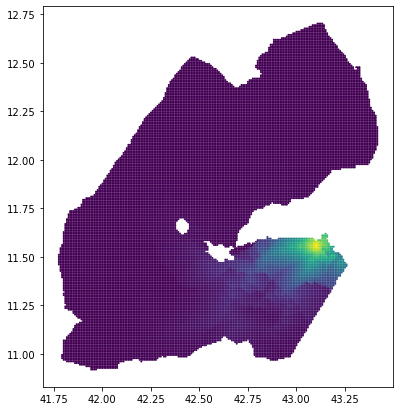

In [71]:
access_cities_results.plot(column='d_5', figsize=(7,7), markersize=1)

In [62]:
for d in range(5,10):
    print(f'writing {d}')
    aggregator.rasterize_gdf(access_cities_results, f'd_{d}', template=raster_path, outFile=os.path.join(output_path,f"access_cities_d{d}.tif"))

writing 5
writing 6
writing 7
writing 8
writing 9


### Make rasters of min travel time to each dest

In [64]:
out_folder

'/home/wb514197/data/INFRA_SAP/DJI/output'

In [65]:
output_path = os.path.join(out_folder, "travel_time")
if not os.path.exists(output_path):
    os.mkdir(output_path)

In [66]:
# CHECK THAT MOST POPULATED CITY IS THE CAPITAL
cap_idx = dest_all.sort_values('Pop', ascending=False).iloc[[0]].index[0]

In [67]:
city_min = pd.DataFrame(origins_join2['city'].min(axis=1).apply(lambda x: (x/3600)), columns=["tt_city"])
ports_min = pd.DataFrame(origins_join2['port'].min(axis=1).apply(lambda x: (x/3600)), columns=["tt_port"])
airports_min = pd.DataFrame(origins_join2['airport'].min(axis=1).apply(lambda x: (x/3600)), columns=["tt_airport"])
borders_min = pd.DataFrame(origins_join2['border'].min(axis=1).apply(lambda x: (x/3600)), columns=["tt_border"])
capital_tt = origins_join2['city'].loc[:,[cap_idx]].apply(lambda x: (x/3600)).rename(columns={cap_idx:'tt_capital'})

In [68]:
origins_tt = origins_snapped.join([city_min, airports_min, borders_min, capital_tt, ports_min])

In [69]:
aggregator.rasterize_gdf(origins_tt, 'tt_city', raster_path, os.path.join(output_path,f"cities_min_tt.tif"))
aggregator.rasterize_gdf(origins_tt, 'tt_port', raster_path, os.path.join(output_path,f"port_min_tt.tif"))
aggregator.rasterize_gdf(origins_tt, 'tt_airport', raster_path, os.path.join(output_path,f"airport_min_tt.tif"))
aggregator.rasterize_gdf(origins_tt, 'tt_border', raster_path, os.path.join(output_path,f"borders_min_tt.tif"))
aggregator.rasterize_gdf(origins_tt, 'tt_capital', raster_path, os.path.join(output_path,f"capital_tt.tif"))